In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
import random
import time

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from data_loader import DataGenerator
from models import VAEmodel, lstmKerasModel
from trainers import vaeTrainer

from utils import process_config, create_dirs, get_args

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

[]


In [5]:
# load VAE model
config = process_config('NAB_config_rerun.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir']])
# create tensorflow session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# create your data generator
#config['dataset'] = 'nprs44'
data = DataGenerator(config)
# create a CNN model
model_vae = VAEmodel(config)
# create a CNN model
trainer_vae = vaeTrainer(sess, model_vae, data, config)
model_vae.load(sess)

Device mapping:




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
conv_1: Tensor("encoder/dense/LeakyRelu:0", shape=(?, 24, 16, 160), dtype=float32)
Instructions for updating:
Use keras.layers.flatten i

In [6]:
print(data.__dict__.keys())
for i in data.__dict__.keys():
    if (i not in ['config','train_set_vae','val_set_vae','test_set_vae','train_set_lstm', 'val_set_lstm']):
        print(i ,getattr(data,i))
for i in  ['train_set_vae','val_set_vae','test_set_vae','train_set_lstm', 'val_set_lstm']:
    print(i ,(getattr(data,i)['data']).shape)




dict_keys(['config', 'n_train_vae', 'n_val_vae', 'train_set_vae', 'val_set_vae', 'test_set_vae', 'n_train_lstm', 'n_val_lstm', 'train_set_lstm', 'val_set_lstm'])
n_train_vae 144761
n_val_vae 16085
n_train_lstm 144523
n_val_lstm 16059
train_set_vae (144761, 24, 16)
val_set_vae (16085, 24, 16)
test_set_vae (512, 24, 16)
train_set_lstm (144523, 12, 24, 16)
val_set_lstm (16059, 12, 24, 16)


In [7]:
config['dataset']

'scada1'

In [8]:
# load LSTM model
lstm_model = lstmKerasModel(data)
lstm_model.produce_embeddings(config, model_vae, data, sess)
lstm_nn_model = lstm_model.create_lstm_model(config)
lstm_nn_model.summary()   # Display the model's architecture

# checkpoint path
checkpoint_path = config['checkpoint_dir_lstm'] + "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# load weights if possible
lstm_model.load_model(lstm_nn_model, config, checkpoint_path)

Finish processing the embeddings of the entire dataset.
The first a few embeddings are
[[ 0.99375951 -3.84024644 -0.60009927  1.47868812  0.31278694 -3.02716374]
 [ 1.00358093 -3.86313772 -0.60885167  1.49387443  0.30029655 -3.06079817]
 [ 1.00194764 -3.86326718 -0.60452694  1.48645842  0.30114365 -3.05708647]
 [ 1.01294053 -3.85925341 -0.60612196  1.49984646  0.30314088 -3.05865073]
 [ 0.98816705 -3.84216642 -0.59964269  1.46695566  0.31714284 -3.02019405]]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 6)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 11, 64)            18176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 11, 64)  

In [9]:
# load normalised time series
save_dir = '../datasets/NAB-known-anomaly/'
dataset = config['dataset']
filename = '{}.npz'.format(dataset)
result = dict(np.load(save_dir+filename, allow_pickle=True))
if dataset == 'machine_temp':
    result['test'] = result['test'][0]
    result['idx_anomaly_test'] = result['idx_anomaly_test'][0]
    result['t_test'] = result['t_test'][0]


In [10]:
def slice_rolling_windows_and_sequences(config, time_seq):
    n_sample = len(time_seq)
    time_seq = np.reshape(time_seq,(-1,config['n_channel']))
    print("The given sequence has {} samples".format(n_sample))
    n_vae_win = n_sample - config['l_win'] + 1
    shape = [n_vae_win, config['l_win'], config['n_channel']]
    stride_ori = time_seq.strides
    strides = np.insert(stride_ori, 0, stride_ori[0], axis = 0)
    #rolling_windows = np.zeros((n_vae_win, config['l_win'], config['n_channel']))
    rolling_windows = np.lib.stride_tricks.as_strided(time_seq,shape, strides, writeable = False)
    #for i in range(n_vae_win):
    #    rolling_windows[i] = time_seq[i:i + config['l_win']]
    sample_m = np.mean(rolling_windows, axis=1)
    sample_std = np.std(rolling_windows, axis=1)
    n_lstm_seq = n_sample - config['l_seq']*config['l_win']+1
    shape = [n_lstm_seq, config['l_seq'], config['l_win'], config['n_channel']]
    strides = np.insert(stride_ori, 0, [stride_ori[-1], stride_ori[0]*config['l_win']], axis = 0)
    lstm_seq = np.lib.stride_tricks.as_strided(time_seq,shape, strides, writeable = False)
    #lstm_seq = np.zeros((n_lstm_seq, config['l_seq'], config['l_win'], config['n_channel']))
    #for i in range(n_lstm_seq):
    #    cur_seq = time_seq[i:i+config['l_seq']*config['l_win']]
    #    for j in range(config['l_seq']):
    #        lstm_seq[i,j] = cur_seq[config['l_win']*j:config['l_win']*(j+1)]
    
    return rolling_windows, lstm_seq, sample_m, sample_std

test_windows, test_seq, test_sample_m, test_sample_std = slice_rolling_windows_and_sequences(config, result['test'])
test_windows = np.reshape(test_windows, (-1,config['l_win'],config['n_channel']))
test_seq = np.reshape(test_seq, (-1,config['l_seq'],config['l_win'],config['n_channel']))
print('test_windows ',test_windows.shape)
print('test_seq ',test_seq.shape)

The given sequence has 68658 samples
test_windows  (68635, 24, 16)
test_seq  (68371, 12, 24, 16)


In [11]:
# Evaluate ELBO and LSTM prediction error on the validation set
# evaluate some anomaly detection metrics
def evaluate_vae_anomaly_metrics_for_a_window(test_win):
    feed_dict = {model_vae.original_signal: np.expand_dims(test_win, 0),
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}

    # VAE reconstruction error
    recons_win_vae = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict))
    test_vae_recons_error = np.sum(np.square(recons_win_vae - test_win)) #them axis=(1,2)

    # VAE latent embedding likelihood
    vae_code_mean, vae_code_std = sess.run([model_vae.code_mean, model_vae.code_std_dev], feed_dict=feed_dict)
    #print(vae_code_mean.shape, vae_code_std.shape)
    test_vae_kl = 0.5 * (np.sum(np.square(vae_code_mean)) + \
                            np.sum(np.square(vae_code_std)) - \
                            np.sum(np.log(np.square(vae_code_std))) - config['code_size']) #them axis=1

    # VAE ELBO loss
    sigma2 = 0.0005
    input_dims = model_vae.input_dims
    sigma_regularisor = input_dims/2. * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error/sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo

def evaluate_lstm_anomaly_metric_for_a_seq(test_seq):
    feed_dict = {model_vae.original_signal: test_seq,
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}
    vae_embedding = np.squeeze(sess.run(model_vae.code_mean, feed_dict=feed_dict))
    #print(vae_embedding.shape)
    lstm_embedding = np.squeeze(lstm_nn_model.predict(np.expand_dims(vae_embedding[:config['l_seq']-1], 0), batch_size=1))
    #print(lstm_embedding.shape)
    lstm_embedding_error = np.sum(np.square(vae_embedding[1:] - lstm_embedding))
    # error_original = vae_embedding[1:] - lstm_embedding
    #print(error_original.shape)
    
    # LSTM prediction error
    feed_dict_lstm = {model_vae.original_signal: np.zeros((config['l_seq'] - 1, config['l_win'], config['n_channel'])),
                      model_vae.is_code_input: True,
                      model_vae.code_input: lstm_embedding}
    recons_win_lstm = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict_lstm))
    lstm_recons_error = np.sum(np.square(recons_win_lstm - np.squeeze(test_seq[1:])))
    error_original = np.abs(recons_win_lstm - np.squeeze(test_seq[1:])).reshape((config['l_seq']-1,-1)) #them dong nay de tinh
    return lstm_recons_error, lstm_embedding_error, error_original


In [12]:

n_val_vae = data.val_set_vae['data'].shape[0]
n_val_lstm = data.val_set_lstm['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in range(n_val_vae):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][i])

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
val_lstm_error_original = np.zeros((n_val_lstm,config['l_seq']-1,config['l_win']*config['n_channel']))
for i in range(n_val_lstm):
    val_lstm_recons_error[i], val_lstm_embedding_error[i], val_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.val_set_lstm['data'][i])
    
n_train_lstm = data.train_set_lstm['data'].shape[0]
train_lstm_recons_error, train_lstm_embedding_error = np.zeros(n_train_lstm), np.zeros(n_train_lstm)
train_lstm_error_original = np.zeros((n_train_lstm,config['l_seq']-1,config['l_win']*config['n_channel'])) #them de tinh OCSVM
for i in range(n_train_lstm):
    train_lstm_recons_error[i], train_lstm_embedding_error[i], train_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.train_set_lstm['data'][i])

In [13]:
np.shape(data.val_set_vae['data'])

(16085, 24, 16)

In [14]:
x = np.arange(12).reshape(3,4)
print (np.sum(x,axis=1))

[ 6 22 38]


In [15]:
#random.seed(1)
#a, b, c = evaluate_vae_anomaly_metrics_for_a_window2(data.val_set_vae['data'])
#random.seed(1)
#a1,b1,c1 = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][0])
#a2,b2,c2 = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][0])
#print(a-val_vae_recons_error)
#print(a1 - val_vae_recons_error[0])
#print(a1-a2)

In [16]:
x = data.val_set_vae['data'][0:7]
y = np.expand_dims(x, 0)
z = np.reshape(x,(-1,config['l_win'],config['n_channel']))
y==z

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  T

In [17]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=True): #sua saveplot tu false thanh true
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+ title +'.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
#     print("Median: {}".format(np.median(test_anomaly_list)))
#     print("Mean: {}".format(np.mean(test_anomaly_list)))
#     print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

25% percentile: 21750.71348286309
75% percentile: 149221.5962701593
These windows scored the top 1% of anomaly metric (1674386.1815426932): 
[  250   251   252   253   254   255   543   544   545  1027  1028  1029
  1030  1267  1268  1269  1739  2260  2582  2583  2587  2621  2622  3148
  3533  3534  3671  3675  3711  3712  3713  3714  3957  3958  3959  3960
  3961  3964  4253  4254  4256  4258  4349  4351  4420  4602  4941  4942
  4943  4944  5041  5042  5043  5387  5691  5692  5693  6484  6485  7013
  7014  7397  7398  7399  7400  7402  7403  8062  8228  8229  8232  8233
  8234  8402  8403  8404  8405  8406  8875  9030  9032  9033  9034  9289
  9290  9295  9909  9910  9911 10432 10433 10434 10435 10750 10751 10757
 10758 10759 11237 11238 11239 11632 11633 11634 11638 11639 11640 11751
 11752 11753 12066 12067 12068 12069 12543 12837 12838 12892 12893 12894
 12901 12902 12903 12904 12923 12924 12925 12926 12959 12960 13203 13429
 13430 13436 13988 13989 13990 13996 13997 14070 14071 1

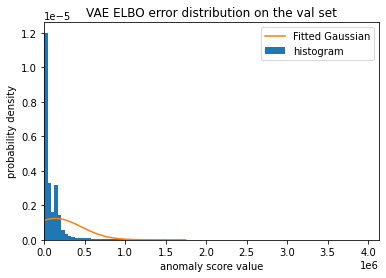

In [18]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

25% percentile: 762.864360655555
75% percentile: 2056.502703504296
These windows scored the top 1% of anomaly metric (5190.423397595454): 
[   143    194    215 ... 144360 144403 144459]


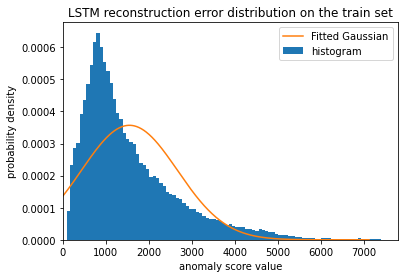

In [19]:
# Histogram of LSTM reconstruction error - train set 
#  --> to decide the anomaly detection threshold
lstm_recons_m_train, lstm_recons_std_train = plot_histogram(train_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the train set', 
                                              mean=None, std=None, xlim=None)

25% percentile: 757.8064443915127
75% percentile: 2036.2644577650146
These windows scored the top 1% of anomaly metric (5233.2711646185035): 
[  176   177   272   430   431   560   763   764   765   838  1094  1095
  1096  1176  1218  1512  1525  1526  1608  1804  1971  1972  2174  2191
  2202  2858  2909  2940  3180  3439  3440  3441  3535  3536  3537  3799
  3800  3828  3859  4176  4177  4193  4238  4438  4439  4480  4526  4563
  4661  4662  4663  4664  4850  4851  4863  4864  4908  4946  4957  5126
  5127  5537  5591  5805  5806  5928  5982  6070  6154  6167  6270  6441
  6442  7092  7093  7128  7455  7456  7565  7736  7737  7738  7933  8148
  8159  8214  8215  8252  8253  8254  8262  8459  8491  8530  8582  8583
  8655  8930  8970  9122  9123  9167  9577  9619  9803  9804 10183 10202
 10203 10213 10259 10260 10491 10492 10493 10494 10539 10906 10915 11206
 11207 11286 11287 11321 11333 11391 11392 11613 11614 11615 11711 11712
 12266 12282 12358 12559 12560 12965 12966 12976 13084 

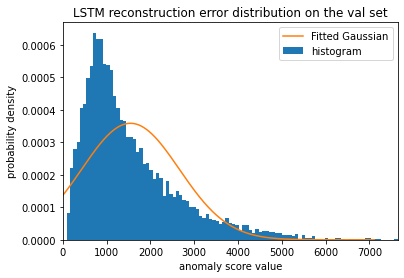

In [20]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m_val, lstm_recons_std_val = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [21]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
test_lstm_error_original = np.zeros((n_test_lstm,config['l_seq']-1,config['l_win']*config['n_channel']))
for i in range(n_test_lstm):
    test_lstm_recons_error[i], test_lstm_embedding_error[i], test_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

All windows' reconstruction error is computed.
The total number of windows is 68371


25% percentile: 3518.0487165070836
75% percentile: 6663.930808824302
These windows scored the top 1% of anomaly metric (10924.360277411526): 
[27427 27443 27451 27452 27459 27483 27491 27507 27515 27523 27547 27555
 27571 27579 27580 27587 27611 27619 27635 27643 27644 27651 27675 27683
 27699 27707 27708 27715 27739 27747 27763 27771 27772 27779 27803 27811
 27827 27835 27836 27843 27867 27875 27891 27899 27907 27931 27939 27955
 27963 27971 27995 28003 28019 28027 28035 28059 28067 28083 28091 28092
 28099 28123 28131 28147 28155 28156 28163 28187 28195 28211 28219 28220
 28227 28251 28259 28275 28281 28283 28284 28287 28291 28293 28297 28299
 28300 28303 28305 28307 28309 28310 28313 28314 28315 28316 28318 28319
 28321 28322 28323 28324 28325 28326 28327 28328 28329 28330 28331 28332
 28334 28335 28337 28338 28339 28341 28342 28343 28345 28346 28347 28348
 28350 28351 28353 28354 28355 28356 28357 28358 28359 28360 28361 28362
 28363 28364 28366 28367 28369 28370 28371 28373 28374 

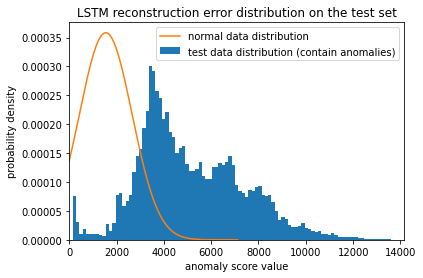

In [22]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m_val, std=lstm_recons_std_val, xlim=None, saveplot=True)

In [23]:
# Produce the ground truth anomaly indices 
# if result['idx_split'][0] == 0:
#     idx_anomaly_test = result['idx_anomaly_test']
# else:
#     idx_anomaly_test = result['idx_anomaly_test'][0]
idx_anomaly_test = result['idx_anomaly_test']    
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in range(len(idx_anomaly_test)):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_test[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    #anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

(68371,)


In [24]:
print(result['idx_anomaly_test'])
print(list(anomaly_index_lstm))
print(test_labels_lstm)

[    3     7    11 ... 68654 68655 68656]
[]
[1. 1. 1. ... 1. 1. 1.]


(5563.52855292545, 5092.49101638125, 5124.768017722603, 1550.5580713040454, 1544.6415304891839)
(2217.92191599769, 2206.205498065775, 2210.2163851727832, 1117.6735364005458, 1113.1491368499653)


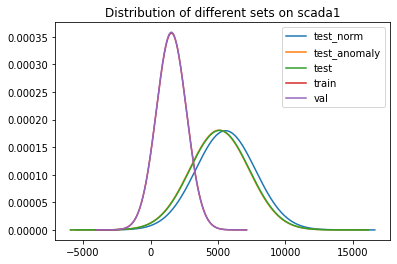

In [25]:
test_normal_idx = np.squeeze(np.argwhere(test_labels_lstm==0))
test_anomaly_idx = np.squeeze(np.argwhere(test_labels_lstm==1))
test_lstm_recons_error_normal = test_lstm_recons_error[test_normal_idx]
test_lstm_recons_error_anomaly = test_lstm_recons_error[test_anomaly_idx]
lstm_recons_m_test_normal = np.mean(test_lstm_recons_error_normal)
lstm_recons_std_test_normal = np.std(test_lstm_recons_error_normal)
lstm_recons_m_test_anomaly = np.mean(test_lstm_recons_error_anomaly)
lstm_recons_std_test_anomaly = np.std(test_lstm_recons_error_anomaly)
lstm_recons_m_test = np.mean(test_lstm_recons_error)
lstm_recons_std_test = np.std(test_lstm_recons_error)

means = (lstm_recons_m_test_normal, lstm_recons_m_test_anomaly, lstm_recons_m_test, lstm_recons_m_train, lstm_recons_m_val)
stds = (lstm_recons_std_test_normal, lstm_recons_std_test_anomaly, lstm_recons_std_test, lstm_recons_std_train, lstm_recons_std_val)
for mean,std in zip(means,stds):
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    #x_axis = np.arange(-10000,10000)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
plt.legend(('test_norm', 'test_anomaly', 'test', 'train', 'val')) 
#plt.xscale('log')
#plt.yscale('log')
plt.title("Distribution of different sets on " + config['dataset'])
#print(lstm_recons_m_test,lstm_recons_std_test)
#print(lstm_recons_m_val,lstm_recons_std_val)
#print(lstm_recons_m_test_normal,lstm_recons_m_test_normal)
print(means)
print(stds)

In [26]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    test_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    idx_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold))
    
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    
    return list(idx_error)

In [27]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    n_anomaly = len(anomaly_index)
    idx_detected_anomaly_extended = list(idx_detected_anomaly)
    for i in range(n_anomaly):
        #print(idx_detected_anomaly)
        for j in idx_detected_anomaly:
            if j in anomaly_index[i]:
                in_original_detection = set(idx_detected_anomaly_extended)
                currect_anomaly_win = set(anomaly_index[i])
                idx_detected_anomaly_extended = idx_detected_anomaly_extended + list(currect_anomaly_win - in_original_detection)
                #print(j)
                break
                
    return list(np.sort(idx_detected_anomaly_extended))

In [28]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP = 0
    n_FP = 0
    #n_detection = len(idx_detected_anomaly)
    #for i in range(n_detection):
    for i in idx_detected_anomaly:    
        #if test_labels[idx_detected_anomaly[i]] == 1:
        if test_labels[i] == 1:    
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1 #both branch the same?
    
    idx_undetected = list(set(np.arange(len(test_labels)))- set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if test_labels[i] == 1:
            n_FN = n_FN + 1
    n_TN = len(test_labels) - n_TP - n_FP - n_FN
    return n_TP, n_FP, n_FN, n_TN

In [29]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    # compute true positive
    n_TP, n_FP, n_FN, n_TN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2* (precision * recall)/(precision + recall)
    fpr = n_FP/(n_FP + n_TN)    
    
    return precision, recall, F1, fpr, n_TP, n_FP, n_FN

In [46]:
n_threshold = 100 #25
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
fpr_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(test_lstm_recons_error), np.amax(test_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, anomaly_index_lstm)
    precision_aug[i], recall_aug[i], F1_aug[i], fpr_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)
    i = i + 1
    #print(precision, recall, F1)    
    
print('threshold list:',threshold_list)

threshold list: [14148.98826715 14007.52895008 13866.06963302 13724.61031596
 13583.1509989  13441.69168184 13300.23236478 13158.77304771
 13017.31373065 12875.85441359 12734.39509653 12592.93577947
 12451.47646241 12310.01714535 12168.55782828 12027.09851122
 11885.63919416 11744.1798771  11602.72056004 11461.26124298
 11319.80192591 11178.34260885 11036.88329179 10895.42397473
 10753.96465767 10612.50534061 10471.04602354 10329.58670648
 10188.12738942 10046.66807236  9905.2087553   9763.74943824
  9622.29012118  9480.83080411  9339.37148705  9197.91216999
  9056.45285293  8914.99353587  8773.53421881  8632.07490174
  8490.61558468  8349.15626762  8207.69695056  8066.2376335
  7924.77831644  7783.31899938  7641.85968231  7500.40036525
  7358.94104819  7217.48173113  7076.02241407  6934.56309701
  6793.10377994  6651.64446288  6510.18514582  6368.72582876
  6227.2665117   6085.80719464  5944.34787758  5802.88856051
  5661.42924345  5519.96992639  5378.51060933  5237.05129227
  5095.59

AUC = 0.4337624184771798


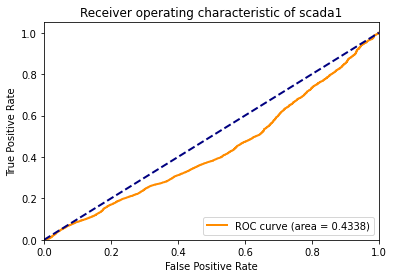

In [47]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(test_labels_lstm,test_lstm_recons_error, pos_label = 1)
auc = metrics.auc(fpr,tpr)
print('AUC =', auc)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of ' + config['dataset'])
plt.legend(loc="lower right")
savefig(config['result_dir']+ 'roc.pdf')
plt.show()

AUC = 0.4338305421969066


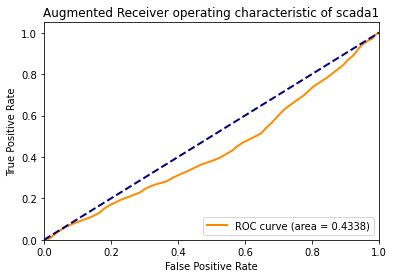

In [48]:
tpr = np.insert(recall_aug,[0,n_threshold],[0,1])
fpr = np.insert(fpr_aug,[0,n_threshold],[0,1])
auc = metrics.auc(fpr,tpr)
print('AUC =', auc)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Augmented Receiver operating characteristic of ' + config['dataset'])
plt.legend(loc="lower right")
savefig(config['result_dir']+ 'augmentedroc.pdf')
plt.show()

In [43]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
best_thres = np.min(threshold_list[idx_best_threshold])
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.9645150542194222
Best threshold is 144.51587805225773
At this threshold, precision is 0.9314757934766711, recall is 0.9999842979618755
Average precision is 0.9199560761831052

Augmented detection:
Best F1 score is 0.9645150542194222
Best threshold is 144.51587805225773
At this threshold, precision is 0.9314757934766711, recall is 0.9999842979618755
Average precision is 0.9199560761831052


In [44]:
import math
from scipy.stats import norm

def KQp(data,q):
#UNTITLED3 Summary of this function goes here
#   Detailed explanation goes here
    data2 = np.sort(data) #sap xep tang dan
    n = np.shape(data2)[0] #kich thuoc
    p = 1-q #q tu xet, dat bang smth 0.05 0.025 0.01
    h = math.sqrt((p*q)/(n+1));
    KQ=0;
    for i in range(1,n+1):
        a= ((i/n)-p)/h;
        b= (((i-1)/n)-p)/h;
        TP=(norm.cdf(a)-norm.cdf(b))*data2[i-1]; #normcdf thu trong matlab
        KQ=KQ+TP;    
    #KQp = KQ;
    return KQ

for i in [0.3, 0.5, 0.7]:
    print("KQp is:", KQp(test_lstm_recons_error,i),"with q =",i)

    

KQp is: 6282.27864082022 with q = 0.3
KQp is: 4689.605721752701 with q = 0.5
KQp is: 3690.88659792995 with q = 0.7


In [35]:
def KQp2(data,q):
    data2 = np.sort(data)
    n= np.shape(data2)[0]
    h = math.sqrt(q*(1-q)/(n+1))
    KQ = 0
    for i in range (1,n+1) :
        a = ((i/n)-q)/h
        b = (((i-1)/n)-q)/h
        TP = (norm.cdf(a)-norm.cdf(b))*data2[i-1]
        KQ = KQ+TP
    return KQ

for i in [0.3, 0.5, 0.7]:
    print("KQp2 is:", KQp2(test_lstm_recons_error,i),"with q =",i)

KQp2 is: 3690.886597929951 with q = 0.3
KQp2 is: 4689.605721752701 with q = 0.5
KQp2 is: 6282.2786408202155 with q = 0.7


MATLAB code KQE:

function KQp = function_KQp(data,q)
%UNTITLED3 Summary of this function goes here
%   Detailed explanation goes here
data2=sort(data,1);
n=size(data2,1);
h=sqrt(q*(1-q)/(n+1));
KQ=0;
for i=1:n
    a=((i/n)-q)/h;
    b= (((i-1)/n)-q)/h;
    TP=(normcdf(a)-normcdf(b))*data2(i);
    KQ=KQ+TP;
end
KQp = KQ;
end

In [50]:
# Now select a threshold
threshold = best_thres
q_list = [0.99, 0.98, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
temp = math.inf
q_best = 0
closest_thres = 0
for q in q_list:
    temp_thres = KQp(test_lstm_recons_error, q)
    #print(temp_thres,abs(temp_thres - threshold))
    if abs(temp_thres - threshold) < temp:
        temp = abs(temp_thres - threshold)
        q_best = q
        KQp_thres = temp_thres
    
print("Closest KQp threshold is {} at q = {}".format(KQp_thres,q_best))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, KQp_thres)
#print(idx_detection)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
#print(anomaly_index_lstm)
#print(idx_detection_augmented)
precision, recall, F1, _, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using KQE:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

print("\nThreshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, _,n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Closest KQp threshold is 273.7296086212964 at q = 0.99

PR evaluation using KQE:
Precision: 0.9314343965606394
Recall: 0.9899506956002889
F1: 0.9598014812784972
TP: 63046
FP: 4641
FN: 640

Threshold is 144.51587805225773

PR evaluation using augmented detection:
Precision: 0.9314757934766711
Recall: 0.9999842979618755
F1: 0.9645150542194222
TP: 63685
FP: 4685
FN: 1


In [37]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [38]:
def plot_detected_anomalies(idx_detection, interval, dataset, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    #t_test = result['t_test']
    test = result['test']
    t_test = np.array(range(result['test'].shape[0]))
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test)
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title("{} dataset test sequence\n(normalised by train mean {:.4f} and std {:.4f})\n Detection method: {}".format(dataset, 
                                                                                        np.mean(result['train_m']), 
                                                                                        np.mean(result['train_std']),
                                                                                        detection_method))
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

In [39]:
[1,3,4] + [1,7,8]

[1, 3, 4, 1, 7, 8]